In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV, LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from scipy.stats import fisher_exact

from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier.threshold import discrimination_threshold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import json

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')

data = data[data['Sector'] == 'Healthcare']

data.head()

,Symbol,Company_Name,Exchange,Orig_Range_Low,Orig_Range_High,Price,Shares,Offer_Amount,ipo_date,is_Friday,...,plustwo_volume_pct,plusthree_change_pct,plusthree_volume_pct,plus90_change_pct,plus90_volume_pct,plus180_change_pct,plus180_volume_pct,d1_d180,d1_pop,d1_d180_pre_price
0,CRGX,Cargo Therapeutics,Nasdaq,15.0,17.0,15.0,18750000,281250000,11/10/23,1,...,0.015489,0.015478,0.008329,0.004261,0.000001,0.028773,1.600000e-09,1,0,1
2,LXEO,Lexeo Therapeutics,Nasdaq,13.0,15.0,11.0,9090910,100000010,11/3/23,1,...,0.013554,-0.005607,0.027481,-0.007088,0.008493,-0.010459,8.693079e-03,1,0,1
7,NMRA,Neumora Therapeutics,Nasdaq,16.0,18.0,17.0,14710000,250070000,9/15/23,1,...,0.064895,0.063768,0.067886,-0.000683,0.013610,-0.073217,2.609517e-01,0,0,0
11,APGE,Apogee Therapeutics,Nasdaq,15.0,17.0,17.0,17650000,300050000,7/14/23,1,...,0.017348,-0.000489,0.012045,-0.018164,0.014629,0.050765,2.699717e-02,1,1,1
16,SLRN,Acelyrin,Nasdaq,16.0,18.0,18.0,30000000,540000000,5/5/23,1,...,0.032103,0.009316,0.031460,0.011814,0.054910,-0.060700,7.077333e-02,0,1,1


In [7]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/exchange.json','r') as f:
    exchange = json.load(f)

In [8]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/sector.json','r') as f:
    sector = json.load(f)

In [9]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/industry.json','r') as f:
    industry = json.load(f)

In [10]:
data['Exchange'] = data['Exchange'].replace(exchange)
data['Sector'] = data['Sector'].replace(sector)
data['Industry'] = data['Industry'].replace(industry)

In [11]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_pop', 'd1_d180'])

In [12]:
data.head()

,Exchange,Price,Shares,Offer_Amount,is_Friday,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,...,vix_min5,vix_min4,vix_min3,vix_min2,vix_min1,vix_min0,sent_negative,sent_neutral,sent_positive,d1_d180_pre_price
0,1,15.0,18750000,281250000,1,2023,4,0.000000,-0.117647,5,...,-0.206291,-0.004106,0.145605,-0.040704,0.236158,-0.193135,0,1,0,1
2,1,11.0,9090910,100000010,1,2023,5,-0.153846,-0.266667,5,...,-0.206291,-0.004106,0.145605,-0.040704,0.236158,-0.140479,0,0,0,1
7,1,17.0,14710000,250070000,1,2023,4,0.062500,-0.055556,5,...,-0.180307,-0.012837,-0.206291,-0.004106,0.145605,-0.135591,0,0,0,0
11,1,17.0,17650000,300050000,1,2023,1,0.133333,0.000000,5,...,-0.007653,0.086039,-0.180307,-0.012837,-0.206291,0.023017,0,1,0,1
16,1,18.0,30000000,540000000,1,2023,3,0.125000,0.000000,5,...,-0.071171,-0.066234,-0.007653,0.086039,-0.180307,0.012384,1,1,0,1


In [13]:
X = data.drop(columns=['d1_d180_pre_price'])
y = data['d1_d180_pre_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

## Full Model

### Logistic Regression

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('classifier', LogisticRegressionCV(max_iter=100000))
])

In [15]:
param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8090)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END ...classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.0s
[CV] END ...classifier__penalty=l1, cl

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=8090, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        LogisticRegressionCV(max_iter=100000))]),
             param_grid={'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'lbfgs',
                                                'newton-cg', 'saga']},
             verbose=2)

In [16]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__penalty,classifier__solver
3,0.553896,0.166339,1,l1,saga
7,0.525974,0.150725,2,l2,saga
0,0.461039,0.156639,3,l1,liblinear
6,0.450649,0.089986,4,l2,newton-cg
4,0.416450,0.122684,5,l2,liblinear
5,0.393290,0.106136,6,l2,lbfgs
1,NaN,NaN,7,l1,lbfgs
2,NaN,NaN,7,l1,newton-cg


In [17]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__penalty,classifier__solver
3,0.553896,0.166339,1,l1,saga
7,0.525974,0.150725,2,l2,saga
0,0.461039,0.156639,3,l1,liblinear
6,0.450649,0.089986,4,l2,newton-cg
4,0.416450,0.122684,5,l2,liblinear
5,0.393290,0.106136,6,l2,lbfgs
1,NaN,NaN,7,l1,lbfgs
2,NaN,NaN,7,l1,newton-cg


In [18]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 LogisticRegressionCV(max_iter=100000, penalty='l1',
                                      solver='saga'))])


In [19]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [20]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[10,  7],
       [33, 41]])

In [21]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.6093241297974211, 5.170057541666402)
p-value for Odds Ratio: 0.41975604737800787


In [22]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.59      0.33        17
           1       0.85      0.55      0.67        74

    accuracy                           0.56        91
   macro avg       0.54      0.57      0.50        91
weighted avg       0.74      0.56      0.61        91



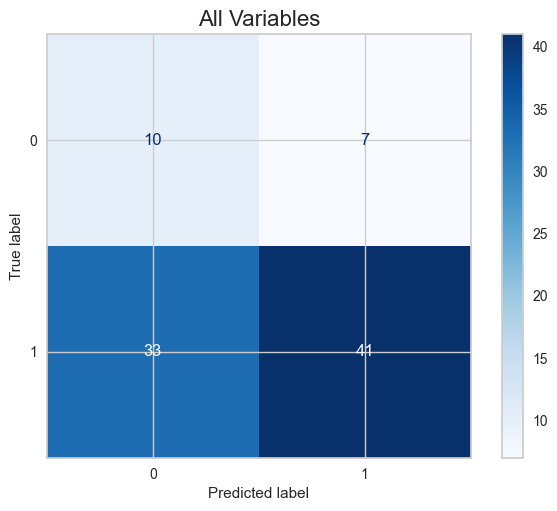

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
# disp.plot()
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lr_tr_full.png', dpi=300, bbox_inches="tight")
plt.show()

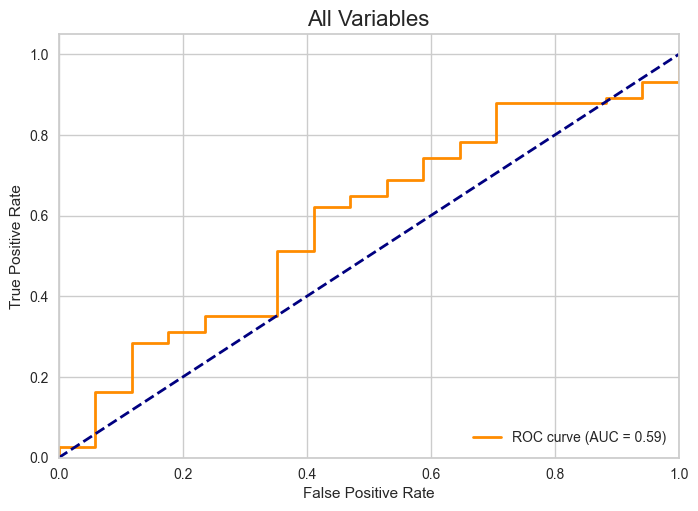

In [24]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lr_tr_full.png', dpi=300, bbox_inches="tight")
plt.show()

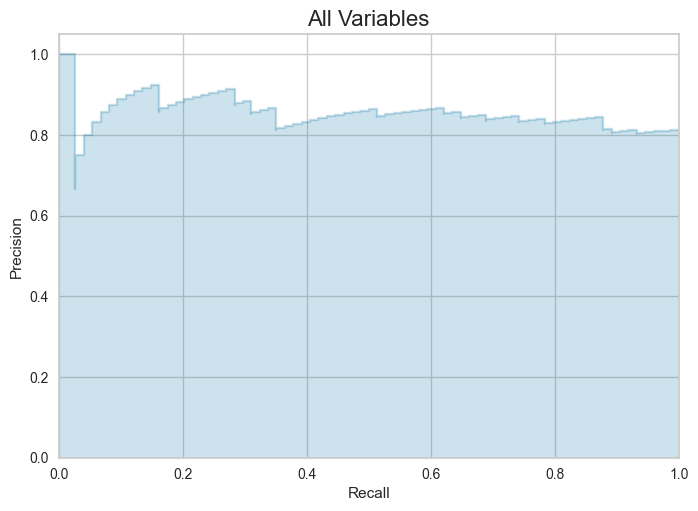

In [25]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lr_full_tr.png', dpi=300, bbox_inches="tight")
plt.show()

In [26]:
# train_sizes, train_scores, test_scores = learning_curve(best_estimator, X, y)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
# display.plot()
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Learning Curve')
# plt.show()

## Reduced Models

### Lasso Regression and Logistic Regression

Lasso Regression is used to build the reduced model, with fewer predictor variables. This model will compared to the full model. 

In [27]:
lasso_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('feature_selection', SelectFromModel(LogisticRegressionCV(penalty="l1", solver='liblinear'))),
    ('classifier', LogisticRegression(max_iter=100000))
])

In [28]:
param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
    'classifier__penalty': ['l1', 'l2']
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8090)

grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=kfold, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END ...classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.0s
[CV] END ...classifier__penalty=l1, cl

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=8090, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegressionCV(penalty='l1',
                                                                                       solver='liblinear'))),
                                       ('classifier',
                                        LogisticRegression(max_iter=100000))]),
             param_grid={'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'lbfgs',
                                                'newton-cg', 'saga']},
             verbose=2)

In [29]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__penalty,classifier__solver
4,0.492208,0.095455,1,l2,liblinear
6,0.473593,0.134759,2,l2,newton-cg
0,NaN,NaN,3,l1,liblinear
1,NaN,NaN,3,l1,lbfgs
2,NaN,NaN,3,l1,newton-cg
3,NaN,NaN,3,l1,saga
5,NaN,NaN,3,l2,lbfgs
7,NaN,NaN,3,l2,saga


In [30]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__penalty,classifier__solver
4,0.492208,0.095455,1,l2,liblinear
6,0.473593,0.134759,2,l2,newton-cg
0,NaN,NaN,3,l1,liblinear
1,NaN,NaN,3,l1,lbfgs
2,NaN,NaN,3,l1,newton-cg
3,NaN,NaN,3,l1,saga
5,NaN,NaN,3,l2,lbfgs
7,NaN,NaN,3,l2,saga


In [31]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('feature_selection',
                 SelectFromModel(estimator=LogisticRegressionCV(penalty='l1',
                                                                solver='liblinear'))),
                ('classifier',
                 LogisticRegression(max_iter=100000, solver='liblinear'))])


In [32]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [33]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[11,  6],
       [37, 37]])

In [34]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.6138461609257028, 5.475494228134343)
p-value for Odds Ratio: 0.29690211241704634


In [35]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.65      0.34        17
           1       0.86      0.50      0.63        74

    accuracy                           0.53        91
   macro avg       0.54      0.57      0.49        91
weighted avg       0.74      0.53      0.58        91



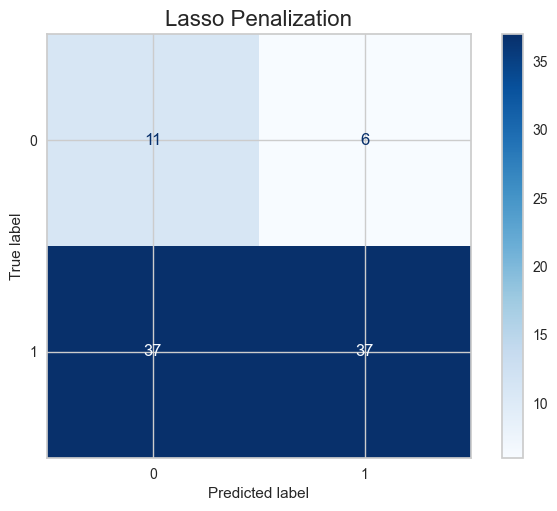

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Lasso Penalization', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lr_tr_red1.png', dpi=300, bbox_inches="tight")
plt.show()

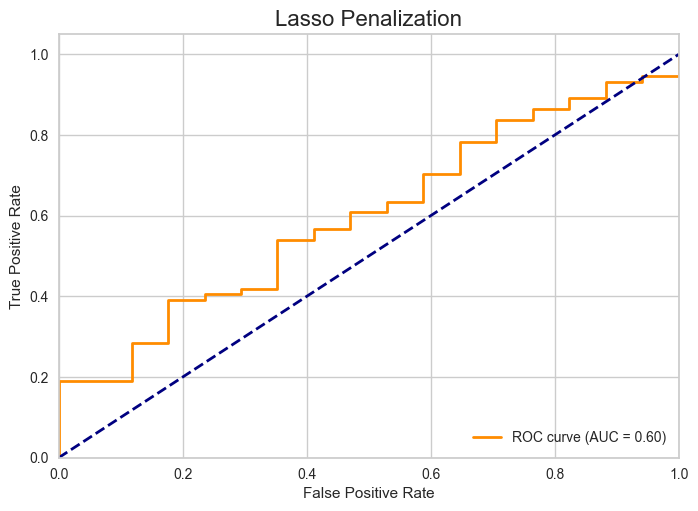

In [37]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lasso Penalization', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lr_tr_red1.png', dpi=300, bbox_inches="tight")
plt.show()

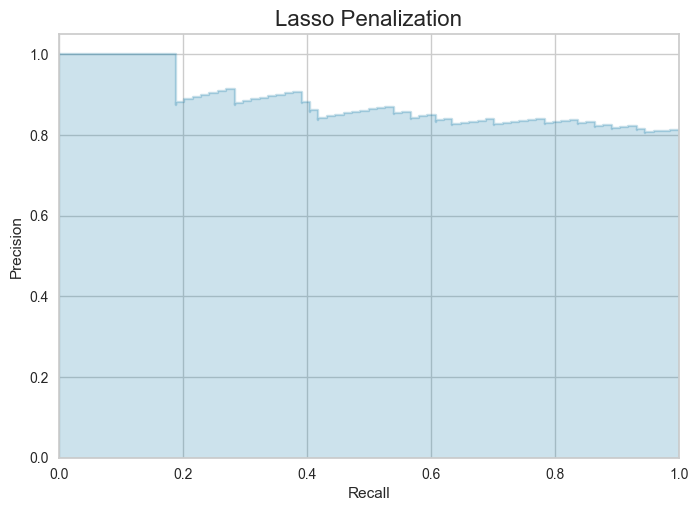

In [38]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Lasso Penalization', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lr_tr_red1.png', dpi=300, bbox_inches="tight")
plt.show()

In [39]:
# train_sizes, train_scores, test_scores = learning_curve(best_estimator, X, y)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
# display.plot()
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Learning Curve')
# plt.show()

## Feature Importance Models and Base Line Models

In [40]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [41]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [42]:
fi_data = X[fi]

In [43]:
fi_data.head()

,Price_Low_Delta,Price_High_Delta,Shares,Offer_Amount,raise_to_ipo_ratio,90_Trailing_IPO_plus95,market_min0,m2_min2,Price,Years_to_IPO,...,vix_min5,inflation_min4,vix_min6,vix_min2,m2_min6,vix_min1,m2_min5,market_min1,Venture_Capital_Round,Debt_OtherEquity
0,0.000000,-0.117647,18750000,281250000,0.556105,14,0.017861,-0.002567,15.0,4,...,-0.206291,0.625,-0.012837,-0.040704,0.004669,0.236158,-0.000605,-0.037117,2,0
2,-0.153846,-0.266667,9090910,100000010,0.337223,11,-0.002889,-0.002567,11.0,5,...,-0.206291,0.625,-0.012837,-0.040704,0.004669,0.236158,-0.000605,-0.037117,3,1
7,0.062500,-0.055556,14710000,250070000,0.290081,14,0.010784,-0.001311,17.0,4,...,-0.180307,0.333,0.086039,-0.004106,-0.011673,0.145605,-0.007464,-0.006441,2,0
11,0.133333,0.000000,17650000,300050000,0.639697,14,0.022409,0.004669,17.0,1,...,-0.007653,0.235,-0.066234,-0.012837,-0.004057,-0.206291,-0.003433,0.024029,2,0
16,0.125000,0.000000,30000000,540000000,0.490909,11,-0.003742,-0.011673,18.0,3,...,-0.071171,1.544,-0.228813,0.086039,-0.002584,-0.180307,-0.004279,0.027951,3,0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

# unique_values = set(X_train['Industry'])

# # Check if at least one sample from each unique value is present in the training set
# for value in unique_values:
#     if value not in X_train['Industry'].unique():
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
#         break

In [46]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('classifier', LogisticRegressionCV(max_iter=100000))
])

In [47]:
param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
    'classifier__penalty': ['l1', 'l2']
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8090)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END ...classifier__penalty=l1, classifier__solver=lbfgs; total time=   0.0s
[CV] END ...classifier__penalty=l1, cl

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=8090, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        LogisticRegressionCV(max_iter=100000))]),
             param_grid={'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'lbfgs',
                                                'newton-cg', 'saga']},
             verbose=2)

In [48]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__penalty,classifier__solver
6,0.577922,0.051450,1,l2,newton-cg
0,0.559957,0.112729,2,l1,liblinear
7,0.554762,0.072257,3,l2,saga
3,0.535065,0.164288,4,l1,saga
5,0.529654,0.127040,5,l2,lbfgs
4,0.525325,0.144436,6,l2,liblinear
1,NaN,NaN,7,l1,lbfgs
2,NaN,NaN,7,l1,newton-cg


In [49]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 LogisticRegressionCV(max_iter=100000, solver='newton-cg'))])


In [50]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [51]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 8,  9],
       [14, 60]])

In [52]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.2479440369570234, 11.629104531574905)
p-value for Odds Ratio: 0.02526831696503566


In [53]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.47      0.41        17
           1       0.87      0.81      0.84        74

    accuracy                           0.75        91
   macro avg       0.62      0.64      0.62        91
weighted avg       0.78      0.75      0.76        91



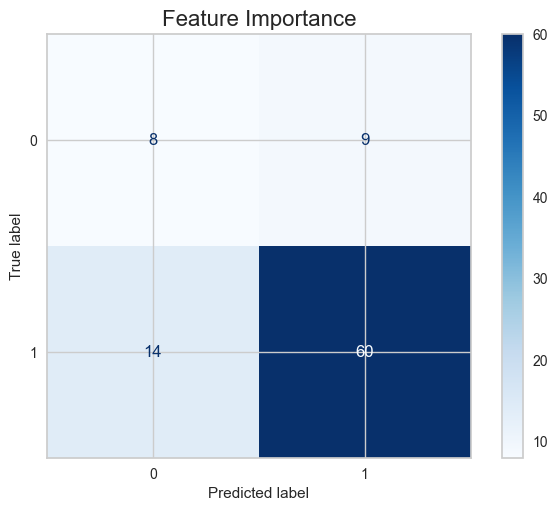

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lr_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

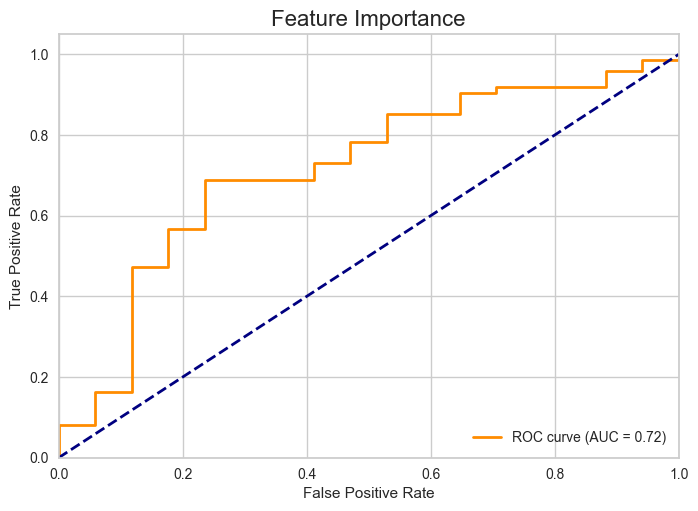

In [55]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lr_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

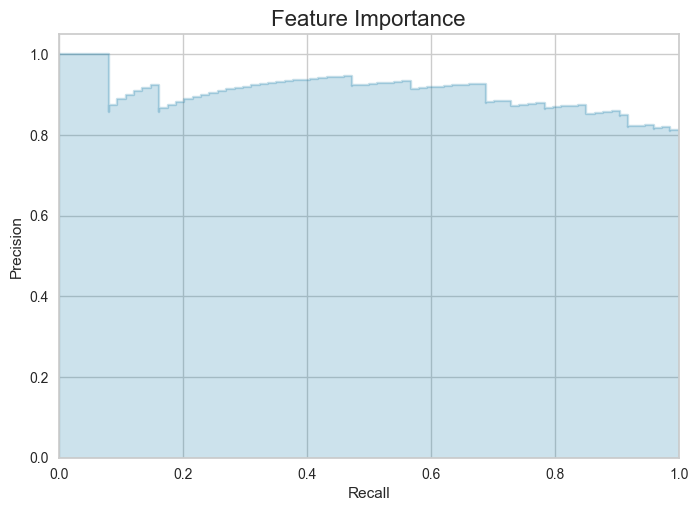

In [56]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lr_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

---
### End of Notebook